In [15]:
# Importar librerias
import pandas as pd
import netCDF4 as nc
import numpy as np
import cv2
import os
import errno
import geopandas as gpd
import seaborn as sns
import shapely
from shapely.geometry import shape, Polygon, Point, MultiPoint, box, LineString
from geopy.distance import geodesic

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import cartopy
from cartopy import config
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from cmcrameri import cm
from cartopy.io.shapereader import Reader as sf
from cartopy.feature import ShapelyFeature as cfeature
import cartopy.io.img_tiles as cimgt

In [16]:
# FUNCIONES UTILES
def clasificar_municipio(lat_mun, lon_mun, lat_ciclon, lon_ciclon, m_perpendicular, direccion_movimiento):
    # Calcular si un municipio está 'delante' o 'detrás' de la línea perpendicular
    y_esperado = m_perpendicular * (lon_mun - lon_ciclon) + lat_ciclon
    
    if direccion_movimiento <= 180:
        return 'Acercando' if lat_mun > y_esperado else 'Alejando'
    else:
        return 'Acercando' if lat_mun < y_esperado else 'Alejando'

# Función para calcular la distancia
def calcular_distancia(row):
    return geodesic(coord_ciclon, (row.centroide.y, row.centroide.x)).km

# Función para calcular el tiempo de arribo
def calcular_tiempo(row):
    distancia_km = geodesic(coord_ciclon, (row.centroide.y, row.centroide.x)).km
    if distancia_km == 0 or velocidad_ciclon_kmh == 0:
        return np.inf
    return distancia_km / velocidad_ciclon_kmh

def configurar_mapa(ax, lon_extent=[-120, -86], lat_extent=[ 14, 30]):
    """
    Configura los elementos comunes del mapa para un subplot ax.
    """
    # Añadir márgenes al mapa
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=2)
    ax.add_feature(cartopy.feature.BORDERS, linewidth=2)
    ax.add_feature(cartopy.feature.LAND.with_scale('50m'), facecolor='lightgrey', alpha=0.8, zorder=0)

    # Configurar los ticks y márgenes con el grosor deseado
    ax.spines['geo'].set_linewidth(3)  # Grosor del contorno exterior del mapa
    ax.tick_params(axis='both', width=3, which='both', labelsize=16)  # Grosor de los ticks

    ax.set_extent(lon_extent + lat_extent, ccrs.PlateCarree())

    ax.set_xticks(np.arange(lon_extent[0], lon_extent[1] + 1, 4), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_extent[0], lat_extent[1] + 1, 4), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    # Añadir líneas de coordenadas cada 3 grados en el eje inferior
    ax.gridlines(draw_labels=False, linewidth=1, color='w', alpha=0.6, linestyle='--', zorder=3,
                 xlocs=range(lon_extent[0], lon_extent[1] + 1, 4), ylocs=range(lat_extent[0], lat_extent[1] + 1, 4))

In [17]:
# TABLA DE ACERCAMIENTO
TA = pd.DataFrame()
TA[0] = [1,1,1,1,1,1]
TA[1] = [2,2,2,2,2,2]
TA[2] = [2,2,2,2,3,3]
TA[3] = [2,2,3,3,3,3]
TA[4] = [2,3,3,3,4,4]
TA[5] = [3,3,4,4,4,4]
TA[6] = [3,4,4,4,4,4]
TA[7] = [4,4,4,4,5,5]
TA[8] = [5,5,5,5,5,5]

def class_h(val):
    if val > 72:
        i = 0
    elif (val <72)&(val>=60):
        i = 1
    elif (val <60)&(val>=48):
        i = 2
    elif (val <48)&(val>=36):
        i = 3
    elif (val <36)&(val>=24):
        i = 4
    elif (val <24)&(val>=18):
        i = 5
    elif (val <18)&(val>=12):
        i = 6
    elif (val <12)&(val>=6):
        i = 7
    elif (val <6):
        i = 8
    return i 

In [18]:
# TABLA DE ALEJAMIENTO
TL = pd.DataFrame()
TL[0] = [5,5,5,5,5,5]
TL[1] = [4,4,5,5,5,5]
TL[2] = [4,4,4,4,5,5]
TL[3] = [3,4,4,4,4,5]
TL[4] = [3,3,3,4,4,4]
TL[5] = [3,3,3,3,4,4]
TL[6] = [2,3,3,3,3,4]
TL[7] = [2,2,2,3,3,3]
TL[8] = [2,2,2,2,2,2]
TL[9] = [1,1,1,1,1,1]

def class_d(val):
    if val < 100:
        i = 0
    elif (val <150)&(val>=100):
        i = 1
    elif (val <200)&(val>=150):
        i = 2
    elif (val <250)&(val>=200):
        i = 3
    elif (val <300)&(val>=250):
        i = 4
    elif (val <350)&(val>=300):
        i = 5
    elif (val <400)&(val>=350):
        i = 6
    elif (val <500)&(val>=400):
        i = 7
    elif (val <750)&(val>=500):
        i = 8
    elif (val >=750):
        i = 9
    return i 

In [19]:
def cambiar_sufijos(df,col):
    lon1 = df[col].to_numpy()
    for i in range(len(lon1)):
        if lon1[i][-1] == 'W':
            lon1[i]  = lon1[i].replace("W","")
            lon1[i] = float(lon1[i]) * -1
        else:
            lon1[i]  = lon1[i].replace("E","").replace("N","")
            lon1[i] = float(lon1[i])
    return lon1

def calculate_danger_level(fraction):
    if fraction == 0:
        return 0
    elif 0 < fraction <= 0.2:
        return 1
    elif 0.2 < fraction <= 0.4:
        return 2
    elif 0.4 < fraction <= 0.6:
        return 3
    elif 0.6 < fraction <= 0.8:
        return 4
    elif 0.8 < fraction <= 1:
        return 5
    return 0  # En caso de cualquier otra eventualidad, se considera peligro 0


In [20]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb

pcp_rain = make_colormap([c('white'),1/20, c('cyan'), 2/20, c('dodgerblue'),
    3/20,c('palegreen'),4/20,c('lawngreen'),5/20,c('yellowgreen'),6/20,c('forestgreen'),
    7/20,c('yellow'),8/20,c('gold'),9/20,c('orange'),10/20, c('darkorange'), 11/20, c('red'),
    12/20,c('firebrick'),13/20,c('maroon'),14/20,c('deeppink'),15/20,c('crimson'),
    16/20,c('mediumvioletred'),17/20,c('violet'),18/20,c('mediumpurple'), 19/20,c('slateblue')])

In [21]:
fname = '../cap_book_ct/destdv1gw/destdv1gw.shp'
estados = gpd.read_file(fname)

# Cargar los datos de trayectoria e información del CT
### Descripcion de la información 

**'NAME'**: Name provided by the agency.

**'ISO_TIME'**: ISO Time provided in Universal Time Coordinates (UTC). Format is YYYY-MM-DD HH mm ss

**'USA_LAT'**: deg north

**'USA_LON'**: deg_east

**'USA_WIND'**: Maximum sustained wind speed in knots: 0 - 300 kts.

**'USA_PRES'**: Minimum sea level pressure, 850 - 1050 mb.

**'USA_SSHS'**: Saffir-Simpson Hurricane Scale information based on the wind speed provided by the US agency wind speed (US agencies provide 1-minute wind speeds): 

        * -5 = Unknown [XX]
        * -4 = Post-tropical [EX, ET, PT]
        * -3 = Miscellaneous disturbances [WV, LO, DB, DS, IN, MD]
        * -2 = Subtropical [SS, SD]
        
        Tropical systems classified based on wind speeds:
        * -1 = Tropical depression (W<34)
        * 0 = Tropical storm [34<W<64]
        * 1 = Category 1 [64<=W<83] 
        * 2 = Category 2 [83<=W<96] 
        * 3 = Category 3 [96<=W<113]
        * 4 = Category 4 [113<=W<137] 
        * 5 = Category 5 [W >= 137]

**'USA_R34_NE'**: 34 kt wind radii maximum extent in northeastern quadrant in nautical milles

**'USA_R34_SE'**: 34 kt wind radii maximum extent in southeastern quadrant in nautical milles

**'USA_R34_SW'**: 34 kt wind radii maximum extent in southwestern quadrant in nautical milles

**'USA_R34_NW'**: 34 kt wind radii maximum extent in northwestern quadrant in nautical milles

**'STORM_SPD'**: Translation speed of the system as calculated from the positions in LAT and LON in knots

**'STORM_DR'**: Translation direction of the system as calculated from the positions in LAT and LON. Direction is moving toward the vector pointing in degrees east of north [range = 0-360 deg]

In [22]:
# tc_tracks = gpd.read_file('../capitulo_otis/IBTrACS.EP.list.v04r00.points.shp')

In [23]:
# GENEVIEVE = tc_tracks[tc_tracks.SEASON.eq(2020) & tc_tracks.NAME.eq('GENEVIEVE')]
# GENEVIEVE.to_file("genevieve_ibtracks.shp")

In [24]:
ct_ibtracs = gpd.read_file('genevieve_ibtracks.shp')
columnas = [5,6,19,20,23,24,25,26,27,28,29,161,162]
ct_ibtracs_info = ct_ibtracs.iloc[:,columnas]

In [25]:
# limpieza para aquellas posiciones que requieren alertamientos (-1 a 5)

df = ct_ibtracs_info[ct_ibtracs_info.USA_SSHS.ge(-1)].copy()

Para empezar es necesario calcular la peligrosidad asociada al SIAT-CT para cada CT. Para ello necesitamos los valores de 

**Escala de Intensidad** : ['ESC_INT'] Categoría del Huracán en la escala Saffir-Simpson o I = 0 si se trata de una Depresión o una Tormenta Tropical.

**Escala de Circulación** : ['ESC_CIR'] la Escala de Circulación y se obtiene de: C = 0.0377 R; donde R es el radio promedio (en millas náuticas) de los cuatro cuadrantes de la isotaca de 34 nudos (63 km/h)

In [26]:
## Escala de intensidad 
df['ESC_INT'] = df['USA_SSHS'].apply(lambda x: x if x >= 1 else 0)

In [27]:
## Escala de circulación
df['R'] = df[['USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW']].mean(axis=1)
df['R'] = df['R'].ffill()
df['ESC_CIR'] = 0.0377 * df['R']
# Ajustar los valores de ESC_CIR para que ningún valor exceda de 5
df['ESC_CIR'] = np.where(df['ESC_CIR'] > 5, 5, df['ESC_CIR'])

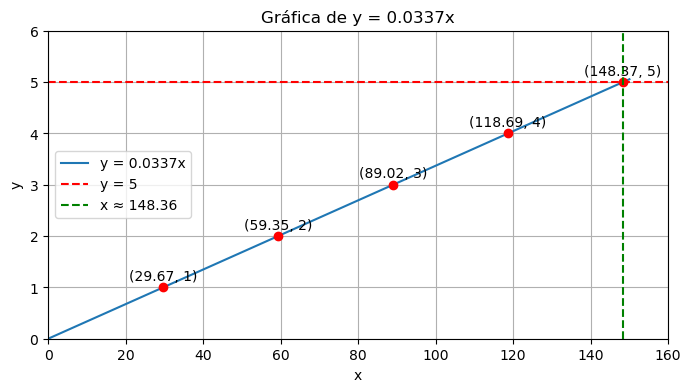

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Valores de x desde 0 hasta 150
x = np.linspace(0, 150, 400)
y = 0.0337 * x

plt.figure(figsize=(8, 4))  # tamaño de la figura
plt.plot(x, y, label='y = 0.0337x')

# Marcas para los puntos donde y es 1, 2, 3, 4, y 5
ys = [1, 2, 3, 4, 5]
xs = [1/0.0337, 2/0.0337, 3/0.0337, 4/0.0337, 5/0.0337]
for i, val in enumerate(ys):
    plt.plot(xs[i], val, 'ro')  # marca los puntos con un círculo rojo
    plt.annotate(f'({xs[i]:.2f}, {val})', (xs[i], val), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('Gráfica de y = 0.0337x')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.axhline(5, color='r', linestyle='--', label='y = 5')
plt.axvline(148.36, color='g', linestyle='--', label='x ≈ 148.36')
plt.legend()
plt.xlim(0, 160)  # ajustar los límites de x
plt.ylim(0, 6)   # ajustar los límites de y
plt.show()


#### Calculo de la peligrosidad del CT con la información antes calculada:
El SIAT CT considera la extensión del ciclón tropical en superficie. Para ello se emplea una Escala
Promedio de las escalas Saffir-Simpson y de Circulación.
La Escala Promedio (e) se obtiene con la siguiente ecuación:
$$e = 0.5 (I+C)$$


In [29]:
# Calcular la Escala Promedio (e) usando la fórmula proporcionada
df['ESC_PEL'] = 0.5 * (df['ESC_INT'] + df['ESC_CIR'])
df['ESC_PEL'] = df['ESC_PEL'].round(2)
df['ESC_PEL'] = df['ESC_PEL'].fillna(0)

#### Cálculo del alertamiento por municipio afectado
Para esto es importante considerar la posición del ciclon tropical y apartir de a dirección de movimiento en grados dados por la columna 'STORM_DR' en un rango de 0 a 360, hay que determinar aquellos municipios de los que se aleja el ciclón y de cuales se acerca. Luego una vez separados los municipios en estos dos grupos hay que determinar dos cosas. Para los que se aleja, la distancia del CT al centro en movimiento. Para los que se acerca en cuanto tiempo el ciclón estará cercano. Y esto en función de la velocidad de traslación o desplazamiento del ciclón tropical el cual esta dada por la columna 'STORM_SPD' donde se expresa en nudos dicha velocidad. Toma en cuenta que la distancia de alejamiento es en KM y el tiempo de acercamiento en Horas.

In [30]:
fname = 'C:/Users/adolf/Downloads/municipios/mun22gw.shp'

shapefile = gpd.read_file(fname,  encoding='utf-8')

In [31]:
names = shapefile[['CVE_ENT','NOM_ENT']].drop_duplicates()

nombres = ['Baja California', 'Baja California Sur', 'Colima', 'Chiapas', 'Guerrero', 'Jalisco', 'Michoacán de Ocampo', 'Nayarit', 'Oaxaca', 'Sinaloa', 'Sonora','Zacatecas', 'Durango', 'Chihuahua']

resultados = names[names['NOM_ENT'].isin(nombres)]
# resultados.CVE_ENT.to_list()

In [32]:
gdf_municipios = shapefile[shapefile['CVE_ENT'].isin(resultados.CVE_ENT.to_list()) ].reset_index(drop =True)

In [33]:
gdf_municipios

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,NOM_ENT,COV_,COV_ID,AREA,PERIMETER,geometry
0,02002,02,002,Mexicali,Baja California,11,13,1.007827e+06,6.486863e+05,"MULTIPOLYGON (((-114.74652 31.80186, -114.7451..."
1,02005,02,005,Playas de Rosarito,Baja California,12,12,5.131454e+04,1.416175e+05,"POLYGON ((-116.67227 32.18235, -116.67589 32.1..."
2,02001,02,001,Ensenada,Baja California,13,16,1.366283e+06,8.975992e+05,"MULTIPOLYGON (((-115.21634 28.37774, -115.2162..."
3,02006,02,006,San Quintín,Baja California,14,18,3.409724e+06,2.114107e+06,"MULTIPOLYGON (((-114.11561 28.09639, -114.1152..."
4,02007,02,007,San Felipe,Baja California,15,17,1.106926e+06,8.765522e+05,"MULTIPOLYGON (((-114.38210 29.82260, -114.3811..."
...,...,...,...,...,...,...,...,...,...,...
1308,32014,32,014,General Francisco R. Murguía,Zacatecas,2470,2467,4.783819e+05,3.970505e+05,"POLYGON ((-102.89148 24.46084, -102.88558 24.4..."
1309,32043,32,043,Susticacán,Zacatecas,2471,2468,1.974781e+04,9.059539e+04,"POLYGON ((-103.10931 22.57209, -103.11083 22.5..."
1310,32045,32,045,Tepechitlán,Zacatecas,2472,2469,5.391230e+04,1.476004e+05,"POLYGON ((-103.15860 21.63311, -103.15928 21.6..."
1311,32046,32,046,Tepetongo,Zacatecas,2473,2470,7.169215e+04,2.022027e+05,"POLYGON ((-103.10931 22.57209, -103.11007 22.5..."


Primero, calculamos el centroide de cada polígono (municipio). Asumiremos que gdf_municipios es tu GeoDataFrame que contiene la geometría de los municipios.

In [34]:
gdf_municipios['centroide'] = gdf_municipios.geometry.centroid
gdf_municipios['lat_centroide'] = gdf_municipios.centroide.y
gdf_municipios['lon_centroide'] = gdf_municipios.centroide.x

C:\Users\adolf\AppData\Local\Temp\ipykernel_24648\2251888287.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_municipios['centroide'] = gdf_municipios.geometry.centroid


In [35]:
df_ciclon =  df.copy()

# A partir de aqui hayq ue determinar el día para los alertaminetos en la variable indice_dia

In [83]:
indice_dia =  3
# Dirección del movimiento del ciclón en grados
ct = df_ciclon.iloc[indice_dia]
direccion_movimiento = df_ciclon['STORM_DR'].iloc[indice_dia] - 180
lat_ciclon, lon_ciclon = df_ciclon['USA_LAT'].iloc[indice_dia], df_ciclon['USA_LON'].iloc[indice_dia]
#20.2069, -91.9754#
# Convertir dirección a radianes
theta_radianes = np.radians(direccion_movimiento)

# Calcular pendiente de la dirección de movimiento y de la perpendicular
m_movimiento = np.tan(theta_radianes)
m_perpendicular = -1/m_movimiento

In [84]:
# Aplicar la función clasificar_municipio a cada fila del GeoDataFrame
nombre_columna = 'clasificacion_'+df_ciclon.iloc[indice_dia].ISO_TIME[:10]
gdf_municipios[nombre_columna] = gdf_municipios.apply(
    lambda x: clasificar_municipio(
        x['lat_centroide'], x['lon_centroide'], 
        lat_ciclon, lon_ciclon, 
        m_perpendicular, direccion_movimiento
    ), axis=1
)

In [85]:
gdf_acercando = gdf_municipios[gdf_municipios[nombre_columna] == 'Acercando'].copy()
gdf_alejando = gdf_municipios[gdf_municipios[nombre_columna] == 'Alejando'].copy()

In [86]:
gdf_acercando

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,NOM_ENT,COV_,COV_ID,AREA,PERIMETER,geometry,centroide,lat_centroide,lon_centroide,clasificacion_2020-08-19,clasificacion_2020-08-16,clasificacion_2020-08-17,clasificacion_2020-08-18,clasificacion_2020-08-20,clasificacion_2020-08-21
0,02002,02,002,Mexicali,Baja California,11,13,1.007827e+06,6.486863e+05,"MULTIPOLYGON (((-114.74652 31.80186, -114.7451...",POINT (-115.32966 32.16922),32.169223,-115.329663,Acercando,Acercando,Acercando,Acercando,Acercando,Acercando
1,02005,02,005,Playas de Rosarito,Baja California,12,12,5.131454e+04,1.416175e+05,"POLYGON ((-116.67227 32.18235, -116.67589 32.1...",POINT (-116.88926 32.25172),32.251719,-116.889259,Acercando,Acercando,Acercando,Acercando,Acercando,Acercando
2,02001,02,001,Ensenada,Baja California,13,16,1.366283e+06,8.975992e+05,"MULTIPOLYGON (((-115.21634 28.37774, -115.2162...",POINT (-116.06052 31.51686),31.516860,-116.060515,Acercando,Acercando,Acercando,Acercando,Acercando,Acercando
3,02006,02,006,San Quintín,Baja California,14,18,3.409724e+06,2.114107e+06,"MULTIPOLYGON (((-114.11561 28.09639, -114.1152...",POINT (-114.51704 29.38446),29.384455,-114.517042,Acercando,Acercando,Acercando,Acercando,Acercando,Acercando
4,02007,02,007,San Felipe,Baja California,15,17,1.106926e+06,8.765522e+05,"MULTIPOLYGON (((-114.38210 29.82260, -114.3811...",POINT (-114.89154 30.68528),30.685280,-114.891542,Acercando,Acercando,Acercando,Acercando,Acercando,Acercando
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,32014,32,014,General Francisco R. Murguía,Zacatecas,2470,2467,4.783819e+05,3.970505e+05,"POLYGON ((-102.89148 24.46084, -102.88558 24.4...",POINT (-102.81160 24.13745),24.137452,-102.811604,Acercando,Acercando,Acercando,Acercando,Alejando,Alejando
1309,32043,32,043,Susticacán,Zacatecas,2471,2468,1.974781e+04,9.059539e+04,"POLYGON ((-103.10931 22.57209, -103.11083 22.5...",POINT (-103.19398 22.63130),22.631298,-103.193980,Acercando,Acercando,Acercando,Acercando,Alejando,Alejando
1310,32045,32,045,Tepechitlán,Zacatecas,2472,2469,5.391230e+04,1.476004e+05,"POLYGON ((-103.15860 21.63311, -103.15928 21.6...",POINT (-103.35673 21.62446),21.624463,-103.356726,Alejando,Acercando,Acercando,Alejando,Alejando,Alejando
1311,32046,32,046,Tepetongo,Zacatecas,2473,2470,7.169215e+04,2.022027e+05,"POLYGON ((-103.10931 22.57209, -103.11007 22.5...",POINT (-103.13684 22.44411),22.444111,-103.136841,Alejando,Acercando,Acercando,Acercando,Alejando,Alejando


In [87]:
import numpy as np

# Datos del ciclón (ejemplo)
lat_ciclon = lat_ciclon  # Latitud del centro del ciclón
lon_ciclon = lon_ciclon  # Longitud del centro del ciclón
direccion_movimiento = direccion_movimiento  # Dirección de movimiento en grados

# Calcular el desplazamiento de la flecha para la dirección del ciclón
longitud_flecha = 1  # Longitud de la flecha en grados, ajusta según la escala de tu mapa
dx = longitud_flecha * np.cos(np.radians(direccion_movimiento))
dy = longitud_flecha * np.sin(np.radians(direccion_movimiento))

# Ahora, incluyendo el centro del ciclón y la dirección en el map





ValueError: aspect must be finite and positive 

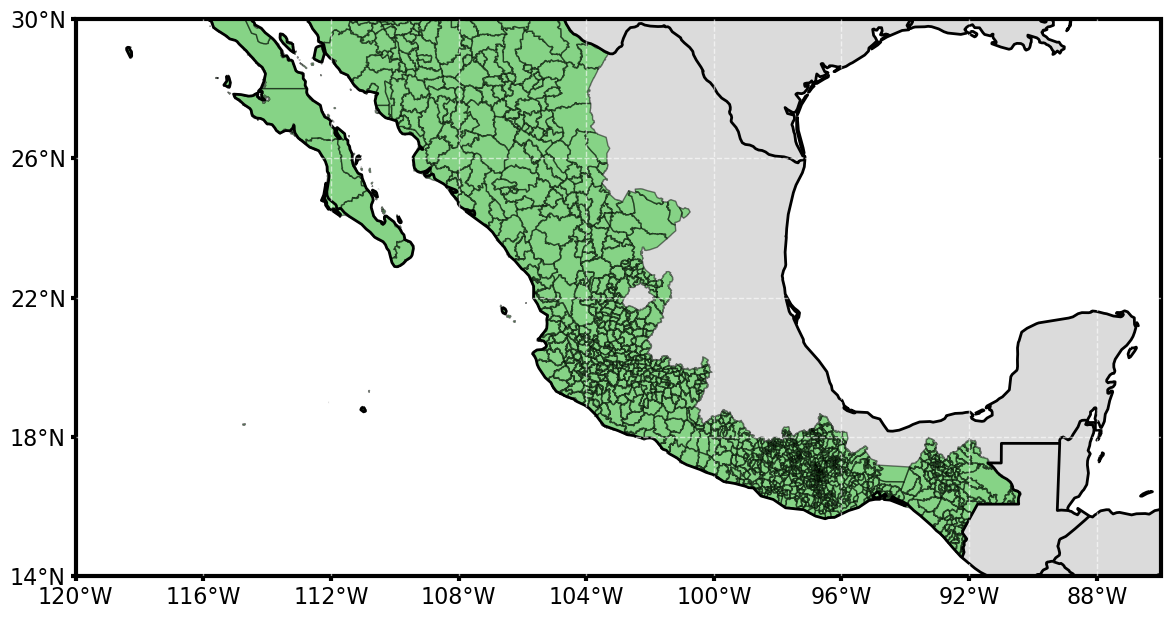

In [88]:
fig, ax = plt.subplots(figsize=(14, 14), subplot_kw={'projection': ccrs.PlateCarree()})
 # Ajusta estos límites para enfocar tu área de interés en Méxicoa x.set_extent([-118, -86, 14, 33], crs=ccrs.PlateCarree()
configurar_mapa(ax)

# Grafica los municipios clasificados
gdf_acercando.plot(ax=ax, color='limegreen', alpha = 0.5, edgecolor='k', label='Acercando', transform=ccrs.PlateCarree())
gdf_alejando.plot(ax=ax, color='yellow', alpha = 0.5, edgecolor='k', label='Alejando', transform=ccrs.PlateCarree())

# Marcar el centro del ciclón
ax.plot(lon_ciclon, lat_ciclon, marker='o', color='red', markersize=10, transform=ccrs.Geodetic(), label='Centro del Ciclón')

# Dibujar la dirección del ciclón
ax.annotate('', xy=(lon_ciclon + dx, lat_ciclon + dy), xytext=(lon_ciclon, lat_ciclon),
            arrowprops=dict(facecolor='red', shrink=0, width=2, headwidth=5),
            transform=ccrs.Geodetic())

# Añade una leyenda y un título
plt.title('Clasificación de Municipios: Acercamiento vs Alejamiento \n CT '+ ct.NAME+' para el '+ct.ISO_TIME)

plt.show()

In [ ]:

# Suponiendo que tienes las coordenadas del centro del ciclón
coord_ciclon = (lat_ciclon, lon_ciclon)

# Aplicar la función a cada fila para los municipios que se alejan
gdf_alejando.loc[:,'distancia_km'] = gdf_alejando.apply(calcular_distancia, axis=1)

In [89]:
df_ciclon['STORM_SPD_KMH'] = df_ciclon['STORM_SPD'] * 1.852
velocidad_ciclon_kmh = df_ciclon['STORM_SPD_KMH'].iloc[indice_dia]

In [90]:
df_ciclon['STORM_SPD_KMH'] = df_ciclon['STORM_SPD'] * 1.852
velocidad_ciclon_kmh = df_ciclon['STORM_SPD_KMH'].iloc[indice_dia]
# Aplicar la función a cada fila para los municipios que se acercan
gdf_acercando.loc[:,'tiempo_arribo_hrs'] = gdf_acercando.apply(calcular_tiempo, axis=1)

In [91]:
peligro_e = round(df_ciclon['ESC_PEL'].iloc[indice_dia])
gdf_acercando.loc[:,'PEL_SIAT'] = gdf_acercando['tiempo_arribo_hrs'].apply(lambda x: TA.loc[peligro_e,class_h(x)])

In [92]:
peligro_e = round(df_ciclon['ESC_PEL'].iloc[indice_dia])
gdf_alejando.loc[:,'PEL_SIAT'] = gdf_alejando['distancia_km'].apply(lambda x: TL.loc[peligro_e,class_d(x)])

KeyError: 'distancia_km'

In [ ]:
siat_ct = pd.concat([gdf_acercando,gdf_alejando])

In [93]:
danger_colors = {
    0: 'grey',
    1: 'dodgerblue',
    2: 'limegreen',
    3: 'yellow',
    4: 'darkorange',
    5: 'red'
}

In [94]:
escala_a_usar = []
for colors in siat_ct.PEL_SIAT.sort_values().unique():
    color_escala =  danger_colors[colors]
    escala_a_usar.append(color_escala)

cmap = ListedColormap(escala_a_usar)

Text(0.5, 1.0, 'Alertamientos del CT GENEVIEVE para el 2020-08-16 21:00:00')

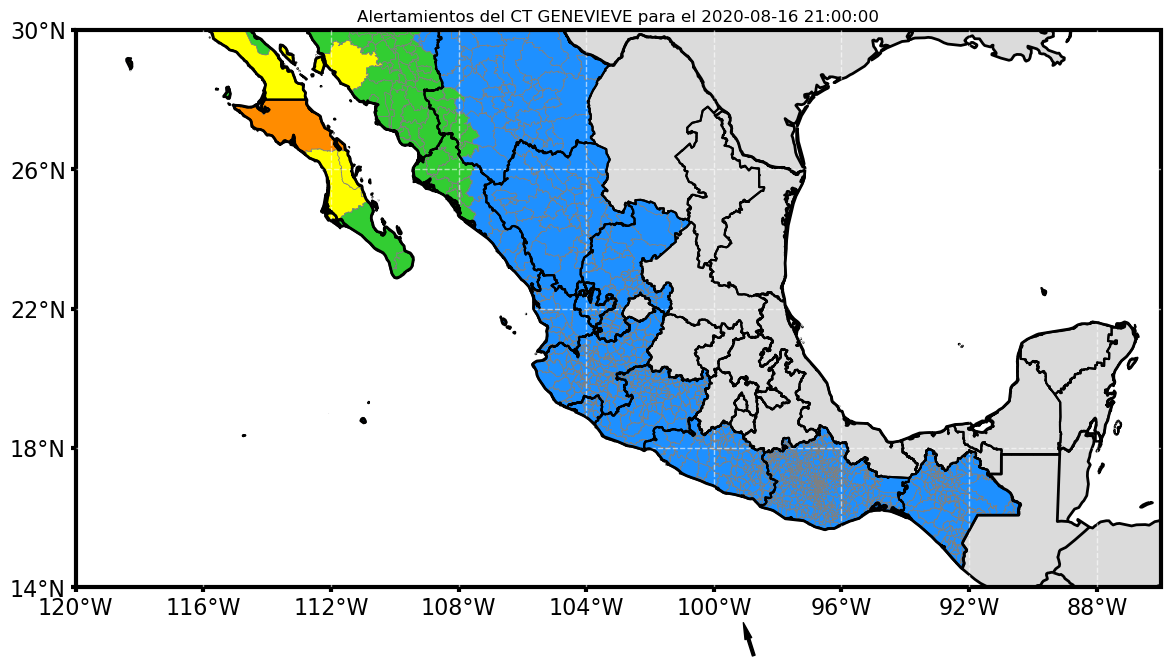

In [95]:
f, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)

siat_ct.plot(column='PEL_SIAT', ax=ax, cmap=cmap, edgecolor='grey', linewidth=0.5)
estados.plot(ax=ax, color = 'none', edgecolor='k', linewidth=1.5, zorder=3)

ax.plot(lon_ciclon, lat_ciclon, marker='o', color='k', markersize=15, transform=ccrs.Geodetic(), label='Centro del Ciclón')
# Dibujar la dirección del ciclón
ax.annotate('', xy=(lon_ciclon + dx, lat_ciclon + dy), xytext=(lon_ciclon, lat_ciclon),
            arrowprops=dict(facecolor='k', shrink=0, width=2, headwidth=5),
            transform=ccrs.Geodetic())

plt.title('Alertamientos del CT '+ct.NAME+' para el '+ct.ISO_TIME)

# plt.savefig("siat_simulacion.jpeg", dpi= 300, bbox_inches='tight')

In [52]:
def ajustar_angulo(angulo):
    angulo_ajustado = 90 - angulo
    if angulo_ajustado < 0:
        angulo_ajustado += 360
    return angulo_ajustado

In [53]:
alertas = gdf_municipios.iloc[:,:10].sort_values('CVEGEO').copy()
for indice_dia in df_ciclon.index:
    # Dirección del movimiento del ciclón en grados
    ct = df_ciclon.iloc[indice_dia]
    direccion_movimiento = ajustar_angulo(df_ciclon['STORM_DR'].iloc[indice_dia])
    lat_ciclon, lon_ciclon = df_ciclon['USA_LAT'].iloc[indice_dia], df_ciclon['USA_LON'].iloc[indice_dia]
    #20.2069, -91.9754#
    # Convertir dirección a radianes
    theta_radianes = np.radians(direccion_movimiento)
    
    # Calcular pendiente de la dirección de movimiento y de la perpendicular
    m_movimiento = np.tan(theta_radianes)
    m_perpendicular = -1/m_movimiento

    # Aplicar la función clasificar_municipio a cada fila del GeoDataFrame
    nombre_columna = 'clasificacion_'+df_ciclon.iloc[indice_dia].ISO_TIME[:10]
    gdf_municipios[nombre_columna] = gdf_municipios.apply(
        lambda x: clasificar_municipio(
            x['lat_centroide'], x['lon_centroide'], 
            lat_ciclon, lon_ciclon, 
            m_perpendicular, direccion_movimiento
        ), axis=1
    )

    gdf_acercando = gdf_municipios[gdf_municipios[nombre_columna] == 'Acercando'].copy()
    gdf_alejando = gdf_municipios[gdf_municipios[nombre_columna] == 'Alejando'].copy()

    # Datos del ciclón (ejemplo)
    lat_ciclon = lat_ciclon  # Latitud del centro del ciclón
    lon_ciclon = lon_ciclon  # Longitud del centro del ciclón
    direccion_movimiento = direccion_movimiento  # Dirección de movimiento en grados
    
    # Calcular el desplazamiento de la flecha para la dirección del ciclón
    longitud_flecha = 1  # Longitud de la flecha en grados, ajusta según la escala de tu mapa
    dx = longitud_flecha * np.cos(np.radians(direccion_movimiento))
    dy = longitud_flecha * np.sin(np.radians(direccion_movimiento))

    
    
    # Suponiendo que tienes las coordenadas del centro del ciclón
    coord_ciclon = (lat_ciclon, lon_ciclon)
    
    # Aplicar la función a cada fila para los municipios que se alejan
    if gdf_alejando.shape[0] > 0 :
        gdf_alejando.loc[:,'distancia_km'] = gdf_alejando.apply(calcular_distancia, axis=1)
        peligro_e = round(df_ciclon['ESC_PEL'].iloc[indice_dia])
        gdf_alejando.loc[:,'PEL_SIAT'] = gdf_alejando['distancia_km'].apply(lambda x: TL.loc[peligro_e,class_d(x)])
    else:
        pass

    df_ciclon['STORM_SPD_KMH'] = df_ciclon['STORM_SPD'] * 1.852
    velocidad_ciclon_kmh = df_ciclon['STORM_SPD_KMH'].iloc[indice_dia]

    if gdf_acercando.shape[0] > 0 :
        gdf_acercando.loc[:,'tiempo_arribo_hrs'] = gdf_acercando.apply(calcular_tiempo, axis=1)
        peligro_e = round(df_ciclon['ESC_PEL'].iloc[indice_dia])
        gdf_acercando.loc[:,'PEL_SIAT'] = gdf_acercando['tiempo_arribo_hrs'].apply(lambda x: TA.loc[peligro_e,class_h(x)])
    else:
        pass    

    siat_ct = pd.concat([gdf_acercando,gdf_alejando])

    nombre_columa = 'alerta-'+ct.ISO_TIME[:10]+'-'+ct.ISO_TIME[11:13]

    alertas = alertas.merge(siat_ct[['CVEGEO','PEL_SIAT']].set_index('CVEGEO'), on = 'CVEGEO')
    alertas = alertas.rename(columns = {'PEL_SIAT':nombre_columa})
    

In [55]:
alertas.columns

Index(['CVEGEO', 'CVE_ENT', 'CVE_MUN', 'NOMGEO', 'NOM_ENT', 'COV_', 'COV_ID',
       'AREA', 'PERIMETER', 'geometry', 'alerta-2020-08-16-12',
       'alerta-2020-08-16-15', 'alerta-2020-08-16-18', 'alerta-2020-08-16-21',
       'alerta-2020-08-17-00', 'alerta-2020-08-17-03', 'alerta-2020-08-17-06',
       'alerta-2020-08-17-09', 'alerta-2020-08-17-12', 'alerta-2020-08-17-15',
       'alerta-2020-08-17-18', 'alerta-2020-08-17-21', 'alerta-2020-08-18-00',
       'alerta-2020-08-18-03', 'alerta-2020-08-18-06', 'alerta-2020-08-18-09',
       'alerta-2020-08-18-12', 'alerta-2020-08-18-15', 'alerta-2020-08-18-18',
       'alerta-2020-08-18-21', 'alerta-2020-08-19-00', 'alerta-2020-08-19-03',
       'alerta-2020-08-19-06', 'alerta-2020-08-19-09', 'alerta-2020-08-19-12',
       'alerta-2020-08-19-15', 'alerta-2020-08-19-18', 'alerta-2020-08-19-21',
       'alerta-2020-08-20-00', 'alerta-2020-08-20-03', 'alerta-2020-08-20-06',
       'alerta-2020-08-20-09', 'alerta-2020-08-20-12', 'alerta-2020-

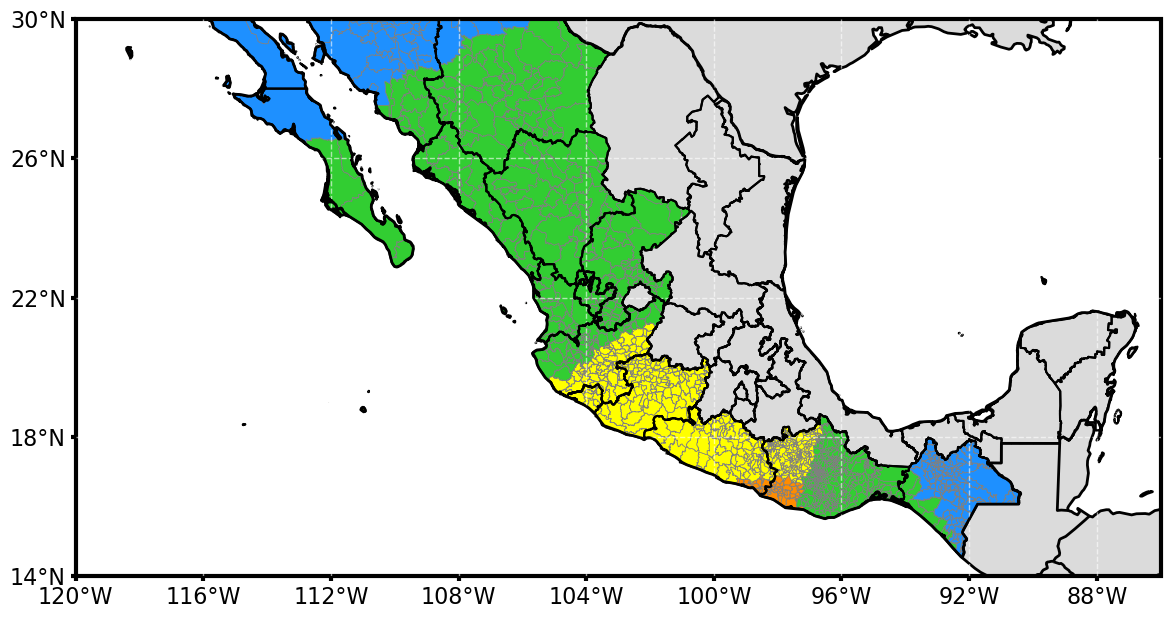

In [99]:
col  =  'alerta-2020-08-16-21'
n_col = col[7:-3] + ' ' +  col[18:]+':00:00'

ct = df_ciclon[df_ciclon.ISO_TIME.eq(n_col)]

escala_a_usar = []
for colors in alertas[col].sort_values().unique():
    color_escala =  danger_colors[colors]
    escala_a_usar.append(color_escala)

cmap = ListedColormap(escala_a_usar)

f, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)

alertas.plot(column=col, ax=ax, cmap=cmap, edgecolor='grey', linewidth=0.5)
estados.plot(ax=ax, color = 'none', edgecolor='k', linewidth=1.5, zorder=3)

ax.plot(ct.USA_LON.values[0], ct.USA_LAT.values[0], marker='o', color='k', markersize= 10, transform=ccrs.Geodetic(), label='Centro del Ciclón')

In [59]:
df_ciclon[df_ciclon.ISO_TIME.isin(['2020-08-17 06:00:00', '2020-08-18 06:00:00', '2020-08-18 12:00:00'])]

,NAME,ISO_TIME,USA_LAT,USA_LON,USA_WIND,USA_PRES,USA_SSHS,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,STORM_SPD,STORM_DR,ESC_INT,R,ESC_CIR,ESC_PEL,STORM_SPD_KMH
6,GENEVIEVE,2020-08-17 06:00:00,12.9,-101.0,55.0,998.0,0,110.0,70.0,50.0,90.0,16.0,301.0,0,80.0,3.0160,1.51,29.632
14,GENEVIEVE,2020-08-18 06:00:00,17.0,-106.6,90.0,970.0,2,130.0,110.0,80.0,100.0,14.0,308.0,2,105.0,3.9585,2.98,25.928
16,GENEVIEVE,2020-08-18 12:00:00,17.7,-107.6,115.0,950.0,4,130.0,110.0,80.0,100.0,10.0,307.0,4,105.0,3.9585,3.98,18.520


## PELIGRO POR VIENTOS 

In [66]:
datos = 'EP122020.dat'
names = ['date', 'time', 'lat', 'lon', 'MWS', 'CPSL', 'ERMWS', 'R34', 'R50', 'R64', 'R100', 'TCOR']
df1 = pd.read_csv(datos, sep=",", skip_blank_lines=True, header = None, names = names)
fecha = pd.to_datetime(df1['date'], format='%Y%m%d').apply(lambda x: pd.Series([x.year,x.month,x.day], index = ['yy', 'mm', 'dd']))
dd = fecha['dd']
mm = fecha['mm']
yy = fecha['yy']
hh = (df1['time']/100).astype(int)
lat = cambiar_sufijos(df1,'lat')
lon = cambiar_sufijos(df1,'lon')
R34 = df1['R34']
ROUT = df1['TCOR']
ERMWS = df1['ERMWS']
d = {'dd':dd,'mm':mm,'yy':yy,'hh':hh,'lat':lat,'lon':lon,'R34':R34,'R':ROUT, 'RMAX':ERMWS}
data = pd.DataFrame(data=d)

In [69]:
data = data.iloc[[3,7,8]] 

In [70]:
municipios_gdf = siat_ct.iloc[:,:11].copy()

In [109]:
# Supongamos que las coordenadas del centro del ciclón y los radios son dados:
indice = 2
centro_ciclon = (data.iloc[indice].lat, data.iloc[indice].lon)  # Ejemplo: Latitud, Longitud
radio_maximo = data.iloc[indice].RMAX  # en kilómetros
radio_limite = data.iloc[indice].R  # en kilómetros
# Crear círculos para cada nivel de peligro
centro = Point(centro_ciclon[::-1])  # Invertir para que sea (lon, lat)
buffer_maximo = centro.buffer(radio_maximo / 111.1)  # Convertir km a grados aprox.
buffer_limite = centro.buffer(radio_limite / 111.1)  # Convertir km a grados aprox.

# Crear los anillos de peligro entre radio máximo y límite
anillos = [buffer_maximo]  # Anillo central de mayor peligro
distancias = np.linspace(radio_maximo, radio_limite, 5)
for i in range(1, len(distancias)):
    anillo_exterior = centro.buffer(distancias[i] / 110.574)
    anillo_interior = centro.buffer(distancias[i - 1] / 110.574)
    anillos.append(anillo_exterior.difference(anillo_interior))


# Inicializar columna de peligro en municipios
municipios_gdf['Peligro'] = 0

# Asignar niveles de peligro basado en intersección de centroides
for i, anillo in enumerate(anillos):
    peligro = 5 - i
    for index, municipio in municipios_gdf.iterrows():
        if municipio['geometry'].centroid.intersects(anillo):
            municipios_gdf.at[index, 'Peligro'] = peligro

In [110]:
escala_a_usar = []
for colors in municipios_gdf.Peligro.sort_values().unique():
    color_escala =  danger_colors[colors]
    escala_a_usar.append(color_escala)

c_scale = ListedColormap(escala_a_usar)

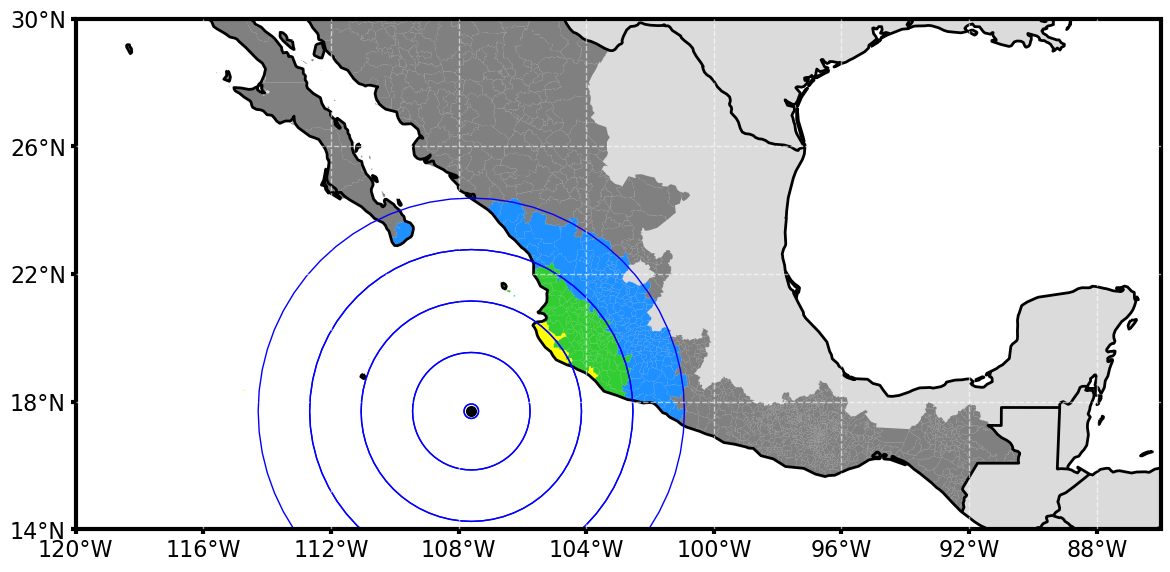

In [111]:
fig3, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)
municipios_gdf.plot(column='Peligro', ax=ax, cmap=c_scale)
for anillo in anillos:
    gpd.GeoSeries([anillo]).boundary.plot(ax=ax, color='blue', linewidth=1)
ax.plot(centro_ciclon[1], centro_ciclon[0], marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')
# nombre = str(data.iloc[indice].yy)+'-'+str(data.iloc[indice].mm)+'-'+str(data.iloc[indice].dd)+'-'+str(data.iloc[indice].hh)
# plt.title('Mapa de Peligro por vientos del '+ nombre)

## PELIGRO POR PRECIPITACION 

In [116]:
names = ['dd','mm','yy','hh','lat', 'lon', 'MWS', 'CPSL',
         'RNE', 'RNO', 'RSO', 'RSE','Rp','A','D','S','TC']
dfNA = pd.read_table('../MAESTRIAtres/800/EP880.dat', names=names, index_col=False )

In [151]:
CRIS_ROC = dfNA[dfNA.TC.eq('EP122020')].copy()
CRIS_ROC = CRIS_ROC.reset_index(drop = True)

# Define el centro y radio del ciclón
indice = 8
center_lon, center_lat = CRIS_ROC.iloc[indice].lon , CRIS_ROC.iloc[indice].lat  # Ejemplo: coordenadas del centro
radius_km = CRIS_ROC.iloc[indice].Rp  # Radio en kilómetros
nombre = str(CRIS_ROC.iloc[indice].yy)+'-'+str(CRIS_ROC.iloc[indice].mm)+'-'+str(CRIS_ROC.iloc[indice].dd)+'-'+str(CRIS_ROC.iloc[indice].hh)

In [152]:
nombre

'2020-8-18-12'

In [206]:
pcpr = '../lluvia/2020234.00.nc'
ds = nc.Dataset(pcpr)
lat = ds.variables['lat'][599:850]
lon = ds.variables['lon'][299:899]
time = ds.variables['time'][0]
pcp = ds.variables['precipitation'][0,599:850,299:899]
lon_grid, lat_grid = np.meshgrid(lon, lat)


In [207]:
nombre = str(CRIS_ROC.iloc[indice].yy)+'-'+str(CRIS_ROC.iloc[indice].mm)+'-'+str(CRIS_ROC.iloc[indice].dd)+'-'+str(CRIS_ROC.iloc[indice].hh)

In [208]:
centro = Point(center_lon,center_lat)  # Invertir para que sea (lon, lat)
circle_deg = centro.buffer(radius_km / 111.1)  # Convertir km a grados aprox.

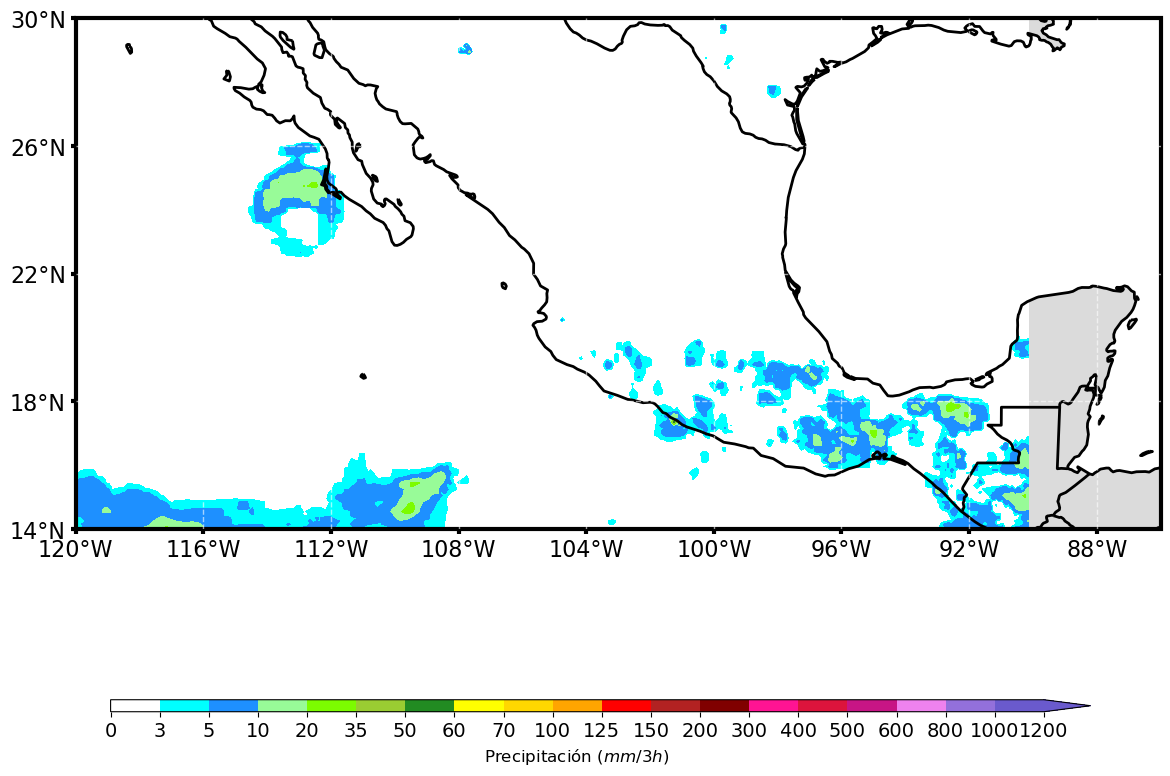

In [209]:
f, ax = plt.subplots(figsize=(14, 12), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)
# Los límites de tus categorías
bins = [0, 3, 5, 10, 20, 35, 50, 60, 70, 100, 125, 150, 200, 300, 400, 500, 600, 800, 1000, 1200]
# ax.plot(center_lon, center_lat, marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')

# Crear la norma con los límites
norm = mcolors.BoundaryNorm(boundaries=bins, ncolors=256)

Q = ax.contourf(lon,lat, pcp, 100,cmap=pcp_rain, norm=norm, transform=ccrs.PlateCarree(),zorder = 1)
sm = plt.cm.ScalarMappable(cmap=pcp_rain, norm=norm)
sm.set_array([])
cbar_ax = f.add_axes([0.15, 0.13, 0.7, 0.01])  # Ajusta las dimensiones [left, bottom, width, height] según necesites
puntos1 = bins  # Ajusta los ticks de la escala de color
cbar = f.colorbar(sm, cax=cbar_ax, ticks=puntos1, orientation='horizontal', extend='max')
cbar.set_label('Precipitación ($mm / 3h$)',fontsize = 12)
cbar.ax.tick_params(labelsize=14)

In [176]:
# Cargar GeoDataFrame de municipios
municipios = siat_ct.iloc[:,:11].copy()

# Proyectar municipios al mismo CRS que el círculo si es necesario
municipios = municipios.to_crs(epsg=4326)  # Asegúrate de que ambos usen WGS84 o ajusta según sea necesario

# Calcular intersección
municipios['intersected'] = municipios['geometry'].intersection(circle_deg)

In [158]:
# Convertir cada punto de precipitación a un punto Shapely
points = [Point(lon, lat) for lon, lat in zip(lon_grid.flatten(), lat_grid.flatten())]
precip_points = gpd.GeoDataFrame({'geometry': points, 'precipitation': pcp.flatten()})

# Filtrar puntos con precipitación > 0 y que están dentro del círculo del ciclón
precip_points = precip_points[precip_points['geometry'].within(circle_deg)]

In [159]:
# Calcular precipitación máxima, acumulada y fracción de puntos con precipitación significativa por municipio
results = []
for index, municipio in municipios.iterrows():
    # Todos los puntos dentro del municipio
    all_points_in_municipio = precip_points[precip_points['geometry'].within(municipio['geometry'])]
    
    # Puntos dentro del municipio con precipitación > 0
    significant_precip_points_in_municipio = all_points_in_municipio[all_points_in_municipio['precipitation'] > 10]
    
    max_precip = significant_precip_points_in_municipio['precipitation'].max() if not significant_precip_points_in_municipio.empty else 0
    total_precip = significant_precip_points_in_municipio['precipitation'].sum()
    
    # Fracción de puntos con precipitación > 0 respecto a todos los puntos posibles dentro del municipio
    if not all_points_in_municipio.empty:
        fraction_significant = len(significant_precip_points_in_municipio) / len(all_points_in_municipio)
    else:
        fraction_significant = 0
    results.append({
        'CVEGEO': municipio['CVEGEO'],
        'municipio': municipio['NOMGEO'],
        'CVE_ENT':municipio['CVE_ENT'],
        'CVE_MUN':municipio['CVE_MUN'],
        'geometry':municipio['geometry'],
        'max_precip': max_precip,
        'total_precip': total_precip,
        'fraction_significant': fraction_significant
    })

results_df = pd.DataFrame(results)

In [160]:
pcp_danger = gpd.GeoDataFrame(results_df,geometry='geometry')
pcp_danger['danger'] = pcp_danger['fraction_significant'].apply(calculate_danger_level)

In [161]:
escala_a_usar = []
for colors in pcp_danger['danger'].sort_values().unique():
    color_escala =  danger_colors[colors]
    escala_a_usar.append(color_escala)

c_scale = ListedColormap(escala_a_usar)

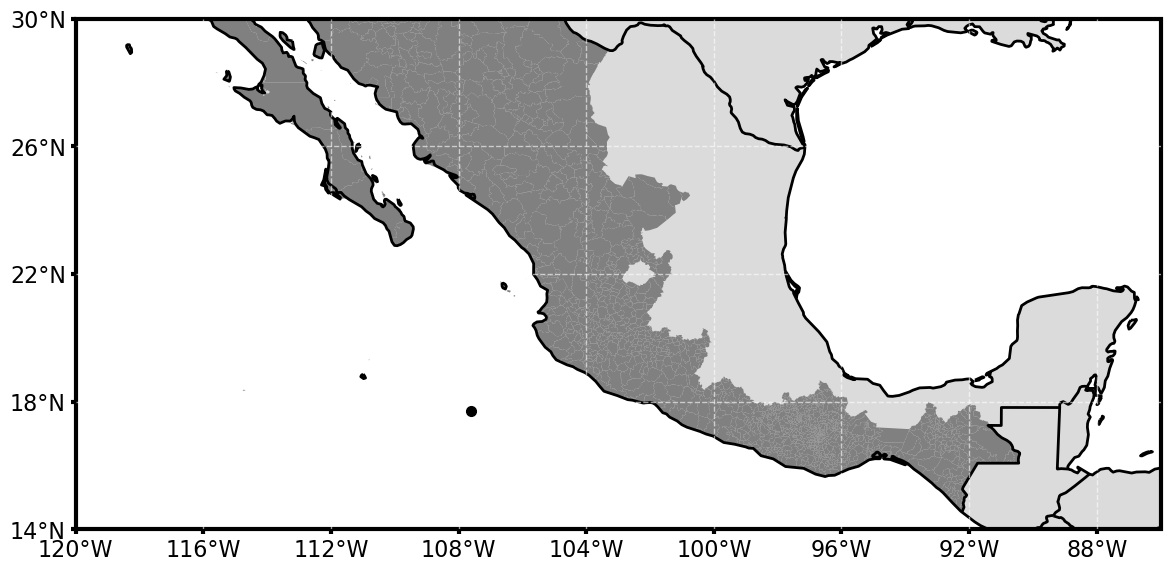

In [162]:
fig5, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)
pcp_danger.plot(column='danger', ax=ax, cmap=c_scale)
ax.plot(center_lon, center_lat, marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')
# plt.title('Mapa de Peligro por Precipitación acumulada en 3h del ' + nombre)

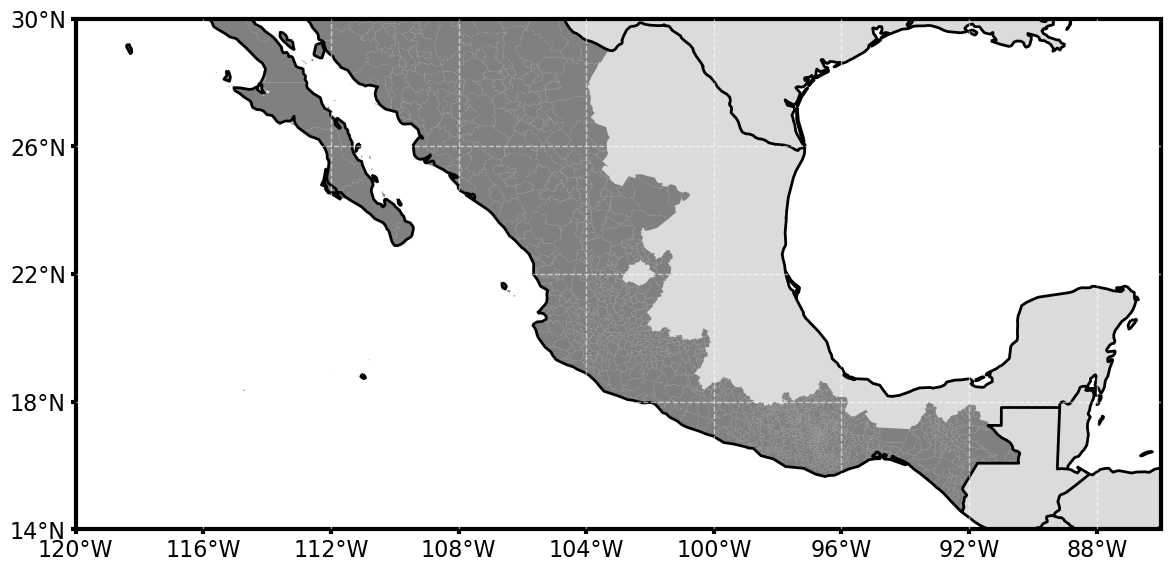

In [138]:
fig4

# PELIGRO POR VIENTOS Y PRECIPITACION EN CONJUNTO (EN PROCESO DE DESARROLLO COMPLEMENTARIO )

In [ ]:
wind_danger = municipios_gdf.copy()
peligro_ct = pcp_danger.merge(wind_danger[['CVEGEO','Peligro']].set_index('CVEGEO'), on = 'CVEGEO')

In [ ]:
peligro_ct = peligro_ct.rename(columns={
    'Peligro': 'wind_danger',  # Cambia 'Peligro' a 'wind_danger'
    'danger': 'pcp_danger'    # Cambia 'danger' a 'pcp_danger'
})
peligro_ct['ct_danger'] = peligro_ct[['wind_danger', 'pcp_danger']].max(axis=1)

In [ ]:
escala_a_usar = []
for colors in peligro_ct['ct_danger'].sort_values().unique():
    color_escala =  danger_colors[colors]
    escala_a_usar.append(color_escala)

c_scale = ListedColormap(escala_a_usar)

In [ ]:
f, ax = plt.subplots(figsize=(14, 18), subplot_kw={"projection":ccrs.PlateCarree()})
configurar_mapa(ax)
ax.plot(center_lon, center_lat, marker='o', color='k', markersize=7, transform=ccrs.Geodetic(), label='Centro del Ciclón')

peligro_ct.plot(column='ct_danger', ax=ax, cmap=c_scale)
plt.title('Alertas promedio ' + nombre)
